In [1]:
import numpy as np
import pandas as pd
from google.colab import drive
import os
import numpy.polynomial.polynomial as poly
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm

!pip install geopandas
import geopandas as gpd

!pip install pycountry
import pycountry as pycountry

     |████████████████████████████████| 972kB 5.4MB/s 
     |████████████████████████████████| 14.8MB 321kB/s 
     |████████████████████████████████| 6.5MB 31.9MB/s 
     |████████████████████████████████| 10.1MB 4.3MB/s 
  Created wheel for pycountry: filename=pycountry-20.7.3-py2.py3-none-any.whl size=10746863 sha256=1af4c27b0efb43c11ffb657444e092ec91d5fc5434eedde47d68e50b9d258775
  Stored in directory: /root/.cache/pip/wheels/33/4e/a6/be297e6b83567e537bed9df4a93f8590ec01c1acfbcd405348
Successfully built pycountry


In [2]:
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Citadel Datathon 2021/London')
!ls

Mounted at /content/drive
 2020_GB_Region_Mobility_Report.csv
 activity_footfall_by_age.csv
 activity_footfall.csv
 activity_homeworking.csv
 activity_retail.csv
 activity_transport.csv
 ageCase.png
 applemobilitytrends-2021-02-16.csv
'Borough population by age groups in percentage.png'
'Borough population by groups in percentage.png'
 Citymapper_Mobility_Index_20210217.csv
 ct01222011censusagebyethnicgroupbysexlondonboroughstcm77353098.csv
 DailyIncreaseBorough.png
 FootfallAgeGrp.png
 google_activity_by_London_Borough.csv
 grocery_and_pharmacy_percent_change_from_baseline.png
 highstreetR.png
'Homeworking by month.xlsx'
 housing-density-borough.csv
 London1.ipynb
 LondonOnly
 londonR.png
 new_cases.png
 ons_infection_survey.csv
 parks_percent_change_from_baseline.png
 parksR.png
 phe_cases_age_london.csv
 phe_cases_london_boroughs.csv
'Population by age-groups (2019).csv'
 R-and-growth-rate-time-series-19-Feb-2021.csv
 residential_percent_change_from_baseline.png
 retail_and_recreati

# Apple Mobility


In [3]:
appleMobility = pd.read_csv('applemobilitytrends-2021-02-16.csv')
appleMobilityLondon = appleMobility.loc[appleMobility['region']=="London"]
appleMobilityLondon

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,geo_type,region,transportation_type,alternative_name,sub-region,country,2020-01-13,2020-01-14,2020-01-15,2020-01-16,2020-01-17,2020-01-18,2020-01-19,2020-01-20,2020-01-21,2020-01-22,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,2020-01-28,2020-01-29,2020-01-30,2020-01-31,2020-02-01,2020-02-02,2020-02-03,2020-02-04,2020-02-05,2020-02-06,2020-02-07,2020-02-08,2020-02-09,2020-02-10,2020-02-11,2020-02-12,2020-02-13,2020-02-14,2020-02-15,...,2021-01-08,2021-01-09,2021-01-10,2021-01-11,2021-01-12,2021-01-13,2021-01-14,2021-01-15,2021-01-16,2021-01-17,2021-01-18,2021-01-19,2021-01-20,2021-01-21,2021-01-22,2021-01-23,2021-01-24,2021-01-25,2021-01-26,2021-01-27,2021-01-28,2021-01-29,2021-01-30,2021-01-31,2021-02-01,2021-02-02,2021-02-03,2021-02-04,2021-02-05,2021-02-06,2021-02-07,2021-02-08,2021-02-09,2021-02-10,2021-02-11,2021-02-12,2021-02-13,2021-02-14,2021-02-15,2021-02-16
541,city,London,driving,NaN,England,United Kingdom,100.0,107.65,111.20,108.29,115.08,122.20,101.06,105.14,112.18,114.32,111.18,118.01,124.14,99.42,103.01,105.92,108.66,109.46,118.35,121.48,103.99,101.60,105.72,110.51,110.47,115.70,123.02,96.79,107.55,109.80,110.74,115.47,124.92,120.86,...,60.09,55.17,46.18,56.60,56.94,56.70,58.55,62.92,54.63,49.50,57.92,58.75,58.32,59.56,65.00,60.13,43.39,57.91,59.33,60.77,62.65,66.91,59.13,52.26,60.93,61.73,62.00,62.63,69.13,63.34,46.89,55.97,57.29,61.59,62.55,69.87,69.81,57.13,69.33,67.93
542,city,London,transit,NaN,England,United Kingdom,100.0,105.14,107.06,106.08,115.13,126.63,104.37,103.68,109.45,112.85,111.52,120.06,130.78,105.11,103.70,105.84,110.18,111.72,124.67,129.92,111.18,104.18,107.19,111.08,111.71,120.48,134.34,103.13,106.62,109.07,111.20,110.18,123.91,131.79,...,33.25,32.92,32.37,33.47,33.13,32.94,32.44,34.10,32.99,34.13,35.14,34.67,34.23,34.56,36.62,36.39,33.49,36.19,34.67,35.25,36.32,37.29,35.55,36.12,36.41,35.92,36.51,36.67,39.61,38.97,35.30,36.45,35.80,37.72,37.17,39.56,39.98,37.20,41.63,41.12
543,city,London,walking,NaN,England,United Kingdom,100.0,108.89,116.84,118.82,132.18,160.29,105.12,108.02,120.52,124.81,127.01,137.38,162.41,97.16,100.01,113.27,122.75,124.96,144.13,161.17,103.93,105.67,115.03,125.42,128.43,140.65,167.80,76.79,100.51,115.26,125.35,124.69,150.77,149.35,...,40.69,47.75,34.23,39.13,39.06,37.09,35.69,42.63,42.88,41.98,40.21,40.42,37.51,41.91,47.02,51.08,30.88,40.03,38.45,40.39,42.00,45.03,39.81,38.67,41.27,42.94,41.89,40.74,49.91,50.46,29.99,36.16,37.43,41.01,40.46,44.48,50.41,40.69,45.97,45.19


In [4]:
# drop useless columns
appleMobilityLondon=appleMobilityLondon.drop(appleMobilityLondon.columns[[0,1,2,3,4,5]],axis=1)
# normalise all by baseline
appleMobilityLondon = appleMobilityLondon.iloc[:,:]-100
appleMobilityLondon

,2020-01-13,2020-01-14,2020-01-15,2020-01-16,2020-01-17,2020-01-18,2020-01-19,2020-01-20,2020-01-21,2020-01-22,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,2020-01-28,2020-01-29,2020-01-30,2020-01-31,2020-02-01,2020-02-02,2020-02-03,2020-02-04,2020-02-05,2020-02-06,2020-02-07,2020-02-08,2020-02-09,2020-02-10,2020-02-11,2020-02-12,2020-02-13,2020-02-14,2020-02-15,2020-02-16,2020-02-17,2020-02-18,2020-02-19,2020-02-20,2020-02-21,...,2021-01-08,2021-01-09,2021-01-10,2021-01-11,2021-01-12,2021-01-13,2021-01-14,2021-01-15,2021-01-16,2021-01-17,2021-01-18,2021-01-19,2021-01-20,2021-01-21,2021-01-22,2021-01-23,2021-01-24,2021-01-25,2021-01-26,2021-01-27,2021-01-28,2021-01-29,2021-01-30,2021-01-31,2021-02-01,2021-02-02,2021-02-03,2021-02-04,2021-02-05,2021-02-06,2021-02-07,2021-02-08,2021-02-09,2021-02-10,2021-02-11,2021-02-12,2021-02-13,2021-02-14,2021-02-15,2021-02-16
541,0.0,7.65,11.20,8.29,15.08,22.20,1.06,5.14,12.18,14.32,11.18,18.01,24.14,-0.58,3.01,5.92,8.66,9.46,18.35,21.48,3.99,1.60,5.72,10.51,10.47,15.70,23.02,-3.21,7.55,9.80,10.74,15.47,24.92,20.86,5.10,21.24,20.38,22.60,23.31,29.10,...,-39.91,-44.83,-53.82,-43.40,-43.06,-43.30,-41.45,-37.08,-45.37,-50.50,-42.08,-41.25,-41.68,-40.44,-35.00,-39.87,-56.61,-42.09,-40.67,-39.23,-37.35,-33.09,-40.87,-47.74,-39.07,-38.27,-38.00,-37.37,-30.87,-36.66,-53.11,-44.03,-42.71,-38.41,-37.45,-30.13,-30.19,-42.87,-30.67,-32.07
542,0.0,5.14,7.06,6.08,15.13,26.63,4.37,3.68,9.45,12.85,11.52,20.06,30.78,5.11,3.70,5.84,10.18,11.72,24.67,29.92,11.18,4.18,7.19,11.08,11.71,20.48,34.34,3.13,6.62,9.07,11.20,10.18,23.91,31.79,16.64,23.55,22.11,25.12,24.27,33.95,...,-66.75,-67.08,-67.63,-66.53,-66.87,-67.06,-67.56,-65.90,-67.01,-65.87,-64.86,-65.33,-65.77,-65.44,-63.38,-63.61,-66.51,-63.81,-65.33,-64.75,-63.68,-62.71,-64.45,-63.88,-63.59,-64.08,-63.49,-63.33,-60.39,-61.03,-64.70,-63.55,-64.20,-62.28,-62.83,-60.44,-60.02,-62.80,-58.37,-58.88
543,0.0,8.89,16.84,18.82,32.18,60.29,5.12,8.02,20.52,24.81,27.01,37.38,62.41,-2.84,0.01,13.27,22.75,24.96,44.13,61.17,3.93,5.67,15.03,25.42,28.43,40.65,67.80,-23.21,0.51,15.26,25.35,24.69,50.77,49.35,-3.97,31.20,31.72,37.59,36.05,53.95,...,-59.31,-52.25,-65.77,-60.87,-60.94,-62.91,-64.31,-57.37,-57.12,-58.02,-59.79,-59.58,-62.49,-58.09,-52.98,-48.92,-69.12,-59.97,-61.55,-59.61,-58.00,-54.97,-60.19,-61.33,-58.73,-57.06,-58.11,-59.26,-50.09,-49.54,-70.01,-63.84,-62.57,-58.99,-59.54,-55.52,-49.59,-59.31,-54.03,-54.81


In [5]:
#insert trenaportation back into dataframe
appleMobilityLondon.insert(0,column='transportation_type', value=['driving','transit','walking'])


In [6]:
# appleMobilityLondon=appleMobilityLondon.fillna(appleMobilityLondon.mean(),inplace=True)
appleMobilityLondon=appleMobilityLondon.dropna(axis=1)

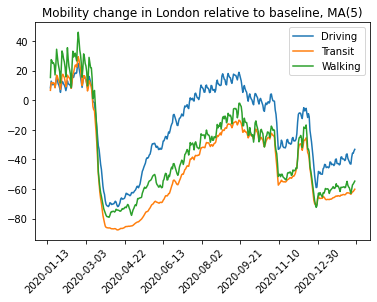

In [7]:
driving = appleMobilityLondon.iloc[0,1:].rolling(window=5).mean()
transit = appleMobilityLondon.iloc[1,1:].rolling(window=5).mean()
walking = appleMobilityLondon.iloc[2,1:].rolling(window=5).mean()

driving.plot(rot=45)
transit.plot(rot=45)
walking.plot(rot=45)
plt.title('Mobility change in London relative to baseline, MA(5)')
plt.legend(['Driving','Transit','Walking'])
plt.show()


In [8]:

# rename for transpose
appleMobilityLondon=appleMobilityLondon.rename({'transportation_type':'date'}, axis='columns')
appleMobilityLondon = appleMobilityLondon.T
appleMobilityLondon.columns=appleMobilityLondon.iloc[0]
appleMobilityLondon= appleMobilityLondon.drop(['date'])
appleMobilityLondon




date,driving,transit,walking
2020-01-13,0,0,0
2020-01-14,7.65,5.14,8.89
2020-01-15,11.2,7.06,16.84
2020-01-16,8.29,6.08,18.82
2020-01-17,15.08,15.13,32.18
...,...,...,...
2021-02-12,-30.13,-60.44,-55.52
2021-02-13,-30.19,-60.02,-49.59
2021-02-14,-42.87,-62.8,-59.31
2021-02-15,-30.67,-58.37,-54.03


(array([0.5, 1.5, 2.5]), <a list of 3 Text major ticklabel objects>)

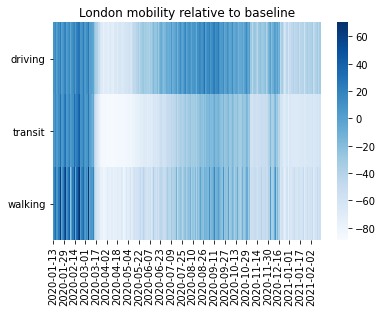

In [9]:

appleMobilityLondon= appleMobilityLondon.apply(pd.to_numeric)
ax = sns.heatmap(appleMobilityLondon.T,cmap="Blues")
ax.set_ylabel('')
ax.set_title('London mobility relative to baseline')
plt.yticks(rotation=0)

# London Boroughs

In [10]:
boroughs = pd.read_csv('/content/drive/MyDrive/Citadel Datathon 2021/London/google_activity_by_London_Borough.csv')
# initialise geometry file for map
map_boroughs  = gpd.read_file('/content/drive/MyDrive/Citadel Datathon 2021/London/statistical-gis-boundaries-london/ESRI/London_Borough_Excluding_MHW.shp')
# initialise infection data
infectionLondon = pd.read_csv('/content/drive/MyDrive/Citadel Datathon 2021/London/phe_cases_london_boroughs.csv')

In [11]:
response = pd.read_csv('/content/drive/MyDrive/Citadel Datathon 2021/2_ecdc/country_response_measures.csv')
response = response.loc[response['Country']=="United Kingdom"]
response['date_start']=  pd.to_datetime(response['date_start'])
response['date_end']=  pd.to_datetime(response['date_end'])

boroughs['date']=  pd.to_datetime(boroughs['date'])

infectionLondon['date'] = pd.to_datetime(infectionLondon['date'])


In [12]:
infectionLondon.sort_values(by=['area_name'], ascending=True)

,area_name,area_code,date,new_cases,total_cases
0,Barking and Dagenham,E09000002,2020-02-11,0,0
2080,Barking and Dagenham,E09000002,2020-04-16,12,430
9696,Barking and Dagenham,E09000002,2020-12-10,210,6008
2112,Barking and Dagenham,E09000002,2020-04-17,9,439
9664,Barking and Dagenham,E09000002,2020-12-09,166,5798
...,...,...,...,...,...
8351,Westminster,E09000033,2020-10-28,48,2491
991,Westminster,E09000033,2020-03-12,14,52
8319,Westminster,E09000033,2020-10-27,77,2443
511,Westminster,E09000033,2020-02-26,1,1


In [13]:
boroughPop = pd.read_csv('/content/drive/MyDrive/Citadel Datathon 2021/London/housing-density-borough.csv')
boroughPop = boroughPop.loc[boroughPop['Year'] == 2020]
boroughPop.head()

,Code,Name,Year,Source,Population,Inland_Area _Hectares,Total_Area_Hectares,Population_per_hectare,Square_Kilometres,Population_per_square_kilometre
21,E09000001,City of London,2020,GLA Population Projections,8046,290.4,314.9,27.7,2.9,2770.7
73,E09000002,Barking and Dagenham,2020,GLA Population Projections,218367,3610.8,3779.9,60.5,36.1,6047.6
125,E09000003,Barnet,2020,GLA Population Projections,407148,8674.8,8674.8,46.9,86.7,4693.4
177,E09000004,Bexley,2020,GLA Population Projections,254970,6058.1,6428.6,42.1,60.6,4208.8
229,E09000005,Brent,2020,GLA Population Projections,343853,4323.3,4323.3,79.5,43.2,7953.6


In [14]:
infectionLondon['newCasePerPop']=""

for i in range(len(infectionLondon)):
  code = infectionLondon.iloc[i,:]['area_code']
  pop = boroughPop.loc[boroughPop['Code']==code]['Population']
  infectionLondon.iloc[i,5] = infectionLondon.iloc[i,:]['new_cases']/int(pop) * 100000

In [15]:
infectionLondon['newCasePerPop'] = pd.to_numeric(infectionLondon['newCasePerPop'])

In [16]:
heatmapLondon = pd.pivot_table(infectionLondon, values ='newCasePerPop', index=['area_name'], columns='date')
heatmapLondon.info()
# date from 11/2/2020 - 17/2/2021, format = mm/dd/yyyy
#create date axis for seaborn to plot as it would just take thr first few
dateAxis = pd.date_range(start='2/11/2020', end = '2/17/2021', periods=24)
# change period (above) according to total below devide(/) by xticklabels
dateAxis = pd.DataFrame(dateAxis)


<class 'pandas.core.frame.DataFrame'>
Index: 32 entries, Barking and Dagenham to Westminster
Columns: 373 entries, 2020-02-11 to 2021-02-17
dtypes: float64(373)
memory usage: 93.5+ KB


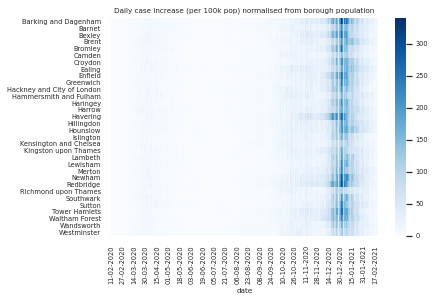

In [17]:
sns.set(font_scale=0.6)
ax = sns.heatmap(heatmapLondon ,cmap='Blues',xticklabels = 16,yticklabels=1)
ax.set_xticklabels(dateAxis[0].dt.strftime('%d-%m-%Y'))
ax.set_ylabel('')
ax.set_title('Daily case increase (per 100k pop) normalised from borough population')
plt.savefig('DailyIncreaseBorough', dpi=1000, bbox_inches='tight')

# Google activity vs boroughs


In [18]:
boroughs.sort_values(['area_code','date'])


,date,area_name,area_code,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
0,2020-02-15,City of London,E09000001,-5.0,-9.0,-12.0,-11,NaN,NaN
1,2020-02-16,City of London,E09000001,-1.0,-21.0,-23.0,-13,NaN,NaN
2,2020-02-17,City of London,E09000001,-3.0,-2.0,4.0,-1,-4.0,NaN
3,2020-02-18,City of London,E09000001,-2.0,-2.0,-1.0,-2,-2.0,NaN
4,2020-02-19,City of London,E09000001,-7.0,-4.0,5.0,0,-4.0,NaN
...,...,...,...,...,...,...,...,...,...
723,2021-02-08,Westminster,E09000033,-91.0,-55.0,-69.0,-81,-74.0,29.0
724,2021-02-09,Westminster,E09000033,-91.0,-54.0,-70.0,-81,-73.0,29.0
725,2021-02-10,Westminster,E09000033,-91.0,-50.0,-67.0,-81,-72.0,28.0
726,2021-02-11,Westminster,E09000033,-91.0,-51.0,-68.0,-82,-71.0,29.0


In [19]:
#drop area_name to merge
boroughs = boroughs.drop(columns=['area_name'])

In [20]:
merged=pd.merge(infectionLondon,boroughs, on=['area_code','date'])
merged.sort_values('date')

,area_name,area_code,date,new_cases,total_cases,newCasePerPop,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
0,Barking and Dagenham,E09000002,2020-02-15,0,0,0.000000,-8.0,-6.0,-12.0,-10,-3.0,2.0
31,Westminster,E09000033,2020-02-15,0,0,0.000000,-11.0,-14.0,-27.0,-3,-1.0,3.0
30,Wandsworth,E09000032,2020-02-15,0,0,0.000000,-12.0,-5.0,-34.0,0,-4.0,2.0
29,Waltham Forest,E09000031,2020-02-15,0,0,0.000000,-12.0,-6.0,-44.0,-7,-3.0,2.0
28,Tower Hamlets,E09000030,2020-02-15,0,0,0.000000,-11.0,-8.0,-31.0,-15,-3.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...
11617,Barnet,E09000003,2021-02-12,48,28918,11.789325,-54.0,-14.0,9.0,-63,-57.0,25.0
11616,Barking and Dagenham,E09000002,2021-02-12,51,22471,23.355177,-43.0,-4.0,-14.0,-50,-47.0,20.0
11646,Wandsworth,E09000032,2021-02-12,45,20916,13.524439,-65.0,-10.0,19.0,-64,-65.0,31.0
11630,Havering,E09000016,2021-02-12,31,25968,11.839743,-57.0,-10.0,-18.0,-53,-53.0,23.0


In [21]:
# London aveerage on dates W/O westminster, outlier
londonAvg = merged[merged['area_name']!="westminster"]

# groupby date and sum cases
temp = londonAvg
temp = temp.drop(columns=['area_code','area_name'])
temp = temp.groupby(pd.Grouper(key='date')).sum()
temp= temp.drop(temp.columns[[2,3,4,5,6,7]],axis=1)


#groupby date and average activities
temp1 = londonAvg
temp1 = temp1.drop(columns=['area_code','area_name'])
temp1 = temp1.groupby(pd.Grouper(key='date')).mean()
temp1= temp1.drop(temp1.columns[[0,1]],axis=1)

# merge both back together
londonAvg = pd.merge(temp,temp1,on='date')
londonAvg = londonAvg.reset_index()

In [22]:
londonAvg

,date,new_cases,total_cases,residential_percent_change_from_baseline_x,newCasePerPop,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline_y
0,2020-02-15,0,1,70.0,0.000000,-9.90625,-6.75000,-33.250000,-7.81250,-2.46875,2.187500
1,2020-02-16,0,1,49.0,0.000000,-10.87500,-10.56250,-45.718750,-9.43750,-3.93750,1.580645
2,2020-02-17,0,1,73.0,0.000000,10.40625,3.53125,17.580645,-3.65625,-12.87500,2.281250
3,2020-02-18,0,1,80.0,0.000000,6.96875,-1.71875,7.781250,-5.56250,-12.53125,2.500000
4,2020-02-19,0,1,86.0,0.000000,5.81250,-2.43750,-5.937500,-6.87500,-12.68750,2.687500
...,...,...,...,...,...,...,...,...,...,...,...
359,2021-02-08,1802,677231,814.0,19.451052,-63.75000,-27.37500,4.290323,-67.18750,-63.75000,25.437500
360,2021-02-09,1660,678891,846.0,17.937330,-63.50000,-24.40625,-3.258065,-68.15625,-63.71875,26.437500
361,2021-02-10,1528,680419,819.0,16.561937,-59.84375,-17.75000,2.419355,-67.03125,-61.34375,25.593750
362,2021-02-11,1437,681856,837.0,15.814580,-60.75000,-17.03125,-2.129032,-67.06250,-61.71875,26.156250


In [23]:
# temp = merged.loc[merged['area_name']=="Westminster"]
# temp.info()
# merged.sort_values(['date'])

In [24]:
londonAvg['parks_percent_change_from_baseline']=londonAvg['parks_percent_change_from_baseline'].rolling(5).mean()

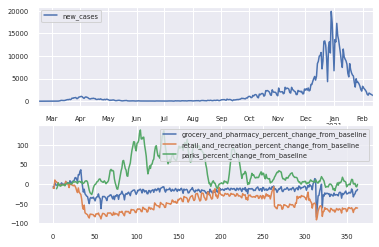

In [25]:
# dont need to plot all, filter out logical useless data
fig, axes = plt.subplots(nrows=2, ncols=1)
londonAvg.plot(ax=axes[0],x='date',y='new_cases')
londonAvg.plot(ax=axes[1],y=['grocery_and_pharmacy_percent_change_from_baseline',
'retail_and_recreation_percent_change_from_baseline','parks_percent_change_from_baseline'])
# temp.plot(ax=axes[2],y='retail_and_recreation_percent_change_from_baseline')
# temp.plot(ax=axes[3],y='parks_percent_change_from_baseline')
# temp.plot(ax=axes[4],y='retail_and_recreation_percent_change_from_baseline')
# temp.plot(ax=axes[5],y='transit_stations_percent_change_from_baseline')
# temp.plot(ax=axes[6],y='workplaces_percent_change_from_baseline')
# temp.plot(ax=axes[7],y='residential_percent_change_from_baseline')

# temp.plot(x='date',y=['new_cases','retail_and_recreation_percent_change_from_baseline','retail_and_recreation_percent_change_from_baseline'])


Change 'Values' to generate whatever heatmap one wants from above

In [26]:
heatmapActivity = pd.pivot_table(merged, values ='new_cases', index=['area_name'], columns='date')


In [27]:
merged

,area_name,area_code,date,new_cases,total_cases,newCasePerPop,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
0,Barking and Dagenham,E09000002,2020-02-15,0,0,0.000000,-8.0,-6.0,-12.0,-10,-3.0,2.0
1,Barnet,E09000003,2020-02-15,0,0,0.000000,-9.0,-5.0,-49.0,-10,-3.0,2.0
2,Bexley,E09000004,2020-02-15,0,0,0.000000,-11.0,-5.0,-31.0,-8,-3.0,2.0
3,Brent,E09000005,2020-02-15,0,0,0.000000,-8.0,-7.0,-28.0,-10,-4.0,2.0
4,Bromley,E09000006,2020-02-15,0,0,0.000000,-12.0,-6.0,-39.0,-11,-4.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...
11643,Sutton,E09000029,2021-02-12,32,15149,15.144560,-53.0,-10.0,5.0,-67,-58.0,24.0
11644,Tower Hamlets,E09000030,2021-02-12,28,27729,8.535466,-69.0,-25.0,-49.0,-73,-70.0,30.0
11645,Waltham Forest,E09000031,2021-02-12,40,23906,13.791962,-42.0,-10.0,-15.0,-61,-58.0,24.0
11646,Wandsworth,E09000032,2021-02-12,45,20916,13.524439,-65.0,-10.0,19.0,-64,-65.0,31.0


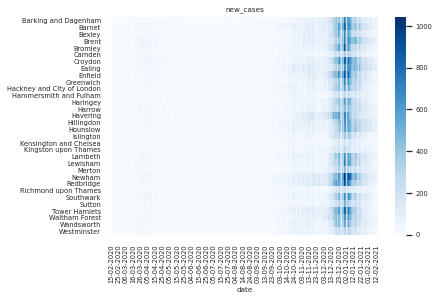

In [28]:
#create date axis for seaborn to plot as it would just take thr first few
dateAxis = pd.date_range(start='2/15/2020', end = '2/12/2021', periods=37)
# change period (above) according to total below devide(/) by xticklabels
dateAxis = pd.DataFrame(dateAxis)

ax=sns.heatmap(heatmapActivity,yticklabels=1,cmap="Blues")
ax.set_xticklabels(dateAxis[0].dt.strftime('%d-%m-%Y'))
plt.ylabel('')
plt.title('new_cases')
plt.savefig('new_cases',dpi=1000, bbox_inches='tight')



```
`# This is formatted as code`
```

# Data with age


In [29]:
footfallAge = pd.read_csv('/content/drive/MyDrive/Citadel Datathon 2021/London/activity_footfall_by_age.csv')
footfallActivity = pd.read_csv('/content/drive/MyDrive/Citadel Datathon 2021/London/activity_footfall.csv')
ageCases = pd.read_csv('/content/drive/MyDrive/Citadel Datathon 2021/London/phe_cases_age_london.csv')


In [30]:
# split data
under25Footfall = footfallAge[footfallAge['merged_age_range']=="Under 25"]
over25Footfall = footfallAge[footfallAge['merged_age_range']=="25 to 64"]
over65Footfall = footfallAge[footfallAge['merged_age_range']=="65 and over"]


In [31]:
#split data
retailFootfall = footfallActivity[footfallActivity['activity']=="Retail & Rec"]
parksFootfall = footfallActivity[footfallActivity['activity']=="Parks"]
walkingFootfall = footfallActivity[footfallActivity['activity']=="Walking"]
highstreetFootfall = footfallActivity[footfallActivity['activity']=="High Street"]


In [32]:
pd.unique(ageCases['age_band'])

array(['0 - 4 years', '5 - 9 years', '10 - 14 years', '15 - 19 years',
       '20 - 24 years', '25 - 29 years', '30 - 34 years', '35 - 39 years',
       '40 - 44 years', '45 - 49 years', '50 - 54 years', '55 - 59 years',
       '60 - 64 years', '65 - 69 years', '70 - 74 years', '75 - 79 years',
       '80 - 84 years', '85 - 89 years', '90+ years', 'unassigned'],
      dtype=object)

In [33]:
#split data
under25Cases = ageCases[(ageCases['age_higher']<25)] 
over25Cases = ageCases[(ageCases['age_lower']>24) &(ageCases['age_higher']<65) ]
over65Cases = ageCases[(ageCases['age_lower']>64)] 


In [34]:
highstreetFootfall

,location,activity,date,change,value,source,roll
1051,Greater London,High Street,2020-02-27,-3.957419,96.042581,Purple,96.815152
1052,Greater London,High Street,2020-02-28,-6.386680,93.613320,Purple,94.906447
1053,Greater London,High Street,2020-02-29,-2.684949,97.315051,Purple,94.675089
1054,Greater London,High Street,2020-03-01,-19.964516,80.035484,Purple,95.152265
1055,Greater London,High Street,2020-03-02,-2.916307,97.083693,Purple,95.144002
...,...,...,...,...,...,...,...
1333,Greater London,High Street,2020-12-05,11.933999,111.933999,Purple,72.592773
1334,Greater London,High Street,2020-12-06,-21.844301,78.155699,Purple,78.585364
1335,Greater London,High Street,2020-12-07,-22.740815,77.259185,Purple,82.559768
1336,Greater London,High Street,2020-12-08,-11.476561,88.523439,Purple,87.752933


In [35]:
footfallAge

,merged_age_range,date,total
0,Under 25,2020-01-01,1.085658
1,Under 25,2020-01-02,1.204019
2,Under 25,2020-01-03,1.236885
3,Under 25,2020-01-04,1.174851
4,Under 25,2020-01-05,0.897833
...,...,...,...
1027,65 and over,2020-12-05,0.273921
1028,65 and over,2020-12-06,0.256610
1029,65 and over,2020-12-07,0.310167
1030,65 and over,2020-12-08,0.347926


Footfall per age group over time

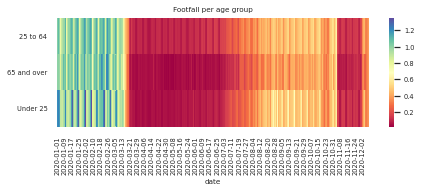

In [36]:
footfallPivot = pd.pivot_table(footfallAge, values='total', index=['merged_age_range'],columns ='date')
fig, ax = plt.subplots(figsize=(7,2))
ax=sns.heatmap(footfallPivot, cmap='Spectral')
ax.set_title('Footfall per age group')
plt.ylabel('')
plt.savefig('FootfallAgeGrp',dpi=1000, bbox_inches='tight')

In [37]:
ageCases

,area_name,area_code,date,age_band,age_lower,age_higher,cases,rolling_rate,rolling_sum,population
0,London,E12000007,2020-01-30,0 - 4 years,0.0,4.0,0,0.0,0,606004.0
1,London,E12000007,2020-01-30,5 - 9 years,5.0,9.0,0,0.0,0,602992.0
2,London,E12000007,2020-01-30,10 - 14 years,10.0,14.0,0,0.0,0,537605.0
3,London,E12000007,2020-01-30,15 - 19 years,15.0,19.0,0,0.0,0,467602.0
4,London,E12000007,2020-01-30,20 - 24 years,20.0,24.0,0,0.0,0,565427.0
...,...,...,...,...,...,...,...,...,...,...
7615,London,E12000007,2021-02-13,75 - 79 years,75.0,79.0,7,74.5,144,193310.0
7616,London,E12000007,2021-02-13,80 - 84 years,80.0,84.0,5,86.9,131,150816.0
7617,London,E12000007,2021-02-13,85 - 89 years,85.0,89.0,6,102.7,96,93461.0
7618,London,E12000007,2021-02-13,90+ years,90.0,90.0,11,179.3,103,57456.0


Daily cases per age group over time


In [38]:
popAgeGroup = pd.read_csv('/content/drive/MyDrive/Citadel Datathon 2021/London/Population by age-groups (2019).csv')
popAgeGroup=popAgeGroup.drop([21,22,23,24,25,26,27])
popAgeGroup.columns = popAgeGroup.iloc[1]
popAgeGroup=popAgeGroup.drop([0,1])
popAgeGroup=popAgeGroup.drop(columns=['Percentage in Rest of England'])

In [39]:
popAgeGroup['Percentage in Inner London']=popAgeGroup['Percentage in Inner London'].str.rstrip('%').astype(float)

popAgeGroup['Percentage in Outer London']=popAgeGroup['Percentage in Outer London'].str.rstrip('%').astype(float)
popAgeGroup['totalLondon'] = popAgeGroup[['Percentage in Inner London','Percentage in Outer London']].mean(axis=1)
popAgeGroup['totalLondon'] = popAgeGroup['totalLondon']/100

In [40]:

popAgeGroup=popAgeGroup.append(popAgeGroup.iloc[[18]])
                    

In [41]:
popAgeGroup

1,Age group,Percentage in Inner London,Percentage in Outer London,totalLondon
2,Aged under 1 year,1.3,1.4,0.0135
3,Aged 1 - 4 years,5.1,5.7,0.0540
4,Aged 5 - 9 years,6.2,7.1,0.0665
5,Aged 10 - 14 years,5.4,6.4,0.0590
6,Aged 15 - 19 years,4.9,5.5,0.0520
7,Aged 20 - 24 years,7.4,5.5,0.0645
8,Aged 25 - 29 years,10.9,7.0,0.0895
9,Aged 30 - 34 years,11.4,7.9,0.0965
10,Aged 35 - 39 years,9.6,8.1,0.0885
11,Aged 40 - 44 years,7.4,7.4,0.0740


In [42]:
# t= pd.DataFrame(popAgeGroup['totalLondon'])
# # t.info()
# ageCasePivot.loc[:,"2020-01-30":"2021-02-13"].info()#.multiply(t,axis=0)
# ageCasePivot.multiply(t,axis=0)

ageCases['casePer100k']=ageCases['cases']/ageCases['population'] * 1000000

In [43]:
# r=ageCases.groupby("age_band").count()
# # ageCasePivot
# tst = pd.pivot_table(ageCases,values='casePer100k', index=['age_band'],columns='date')
# sns.heatmap(tst)

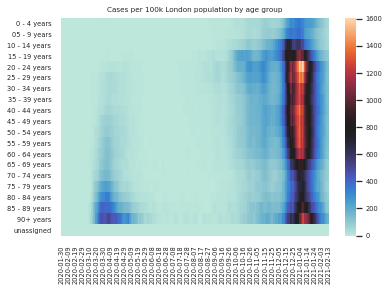

In [44]:
ageCasePivot = pd.pivot_table(ageCases,values='rolling_rate', index=['age_band'],columns='date')
# sort index
ageCasePivot = ageCasePivot.rename(index={'5 - 9 years':'05 - 9 years'})
ageCasePivot=ageCasePivot.sort_values('age_band',ascending=True)

sns.heatmap(ageCasePivot,cmap='icefire')
plt.title('Cases per 100k London population by age group')
plt.ylabel('')
plt.xlabel('')

plt.savefig('ageCase',dpi=1000, bbox_inches='tight')

In [45]:
footfallActivity

,location,activity,date,change,value,source,roll
0,Greater London,Retail & Rec,2020-02-27,0.000000,100.000000,Google,101.285714
1,Greater London,Parks,2020-02-27,4.000000,104.000000,Google,102.285714
2,Greater London,Retail & Rec,2020-02-28,-2.000000,98.000000,Google,102.142857
3,Greater London,Parks,2020-02-28,-9.000000,91.000000,Google,101.000000
4,Greater London,Retail & Rec,2020-02-29,-2.000000,98.000000,Google,100.000000
...,...,...,...,...,...,...,...
1333,Greater London,High Street,2020-12-05,11.933999,111.933999,Purple,72.592773
1334,Greater London,High Street,2020-12-06,-21.844301,78.155699,Purple,78.585364
1335,Greater London,High Street,2020-12-07,-22.740815,77.259185,Purple,82.559768
1336,Greater London,High Street,2020-12-08,-11.476561,88.523439,Purple,87.752933


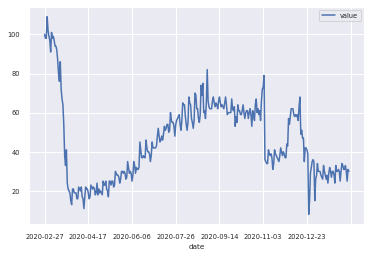

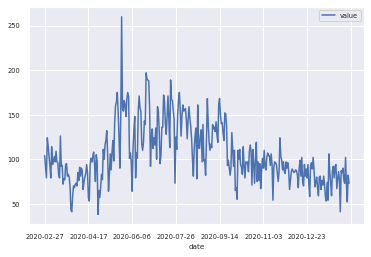

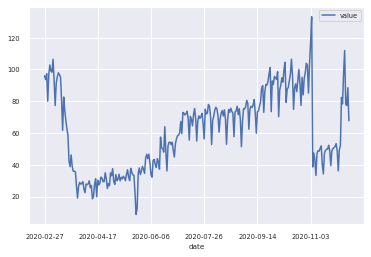

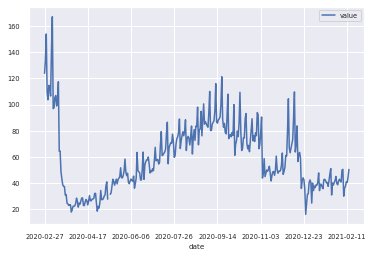

In [46]:
# act = footfallActivity.activity.value_counts().index
# g = sns.FacetGrid(footfallActivity, row="activity", row_order= act)
# g.map(sns.kdeplot, x="date",y="value")

retailFootfall.plot(x="date",y="value")
parksFootfall.plot(x='date',y="value")
highstreetFootfall.plot(x="date",y="value")
walkingFootfall.plot(x="date",y="value")


In [47]:
rRate = pd.read_csv('/content/drive/MyDrive/Citadel Datathon 2021/London/R-and-growth-rate-time-series-19-Feb-2021.csv')

In [48]:
rRate.columns = ['Date','Lbound','Hbound']

In [49]:
rRate['Date']=pd.to_datetime(rRate['Date'])
rRate['Hbound'] = pd.to_numeric(rRate['Hbound'], errors = 'coerce')
rRate['Lbound'] = pd.to_numeric(rRate['Lbound'], errors = 'coerce')
rRate['mean'] = rRate[['Lbound','Hbound']].mean(axis=1)
rRate.dropna(axis='rows')

,Date,Lbound,Hbound,mean
1,2020-06-12,0.8,1.0,0.90
2,2020-06-19,0.7,1.0,0.85
3,2020-06-26,0.6,0.9,0.75
4,2020-07-03,0.8,1.1,0.95
5,2020-07-10,0.7,1.0,0.85
6,2020-07-17,0.8,1.1,0.95
7,2020-07-24,0.8,1.0,0.90
8,2020-07-31,0.8,1.0,0.90
9,2020-08-07,0.8,1.1,0.95
10,2020-08-14,0.8,1.0,0.90


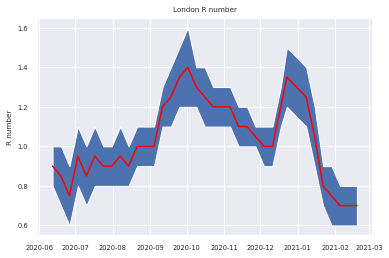

In [50]:
plt.plot(rRate['Date'],rRate['mean'], color='red')
plt.fill_between(rRate.Date, rRate.Lbound, rRate.Hbound)
plt.ylabel('R number')
plt.title('London R number')
plt.savefig('londonR',dpi=1000, bbox_inches='tight')

In [51]:
retailFootfall['date'] = pd.to_datetime(retailFootfall['date'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


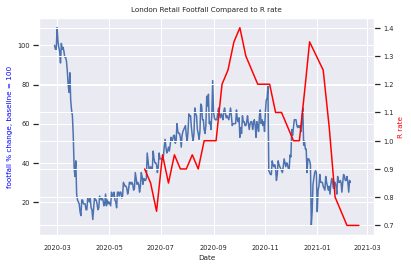

In [52]:
fig, ax = plt.subplots()
ax.plot(retailFootfall["date"],retailFootfall["value"])
ax.set_ylabel('footfall % change, baseline = 100',color='blue')
ax.set_xlabel('Date')

ax2 = ax.twinx()
ax2.set_ylabel('R rate',color='red')
ax2.plot(rRate['Date'],rRate['mean'], color='red')
# ax2.fill_between(rRate.Date, rRate.Lbound, rRate.Hbound)
plt.title('London Retail Footfall Compared to R rate')

plt.savefig('retailR',dpi=1000, bbox_inches='tight')

In [53]:
parksFootfall['date'] = pd.to_datetime(parksFootfall['date'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


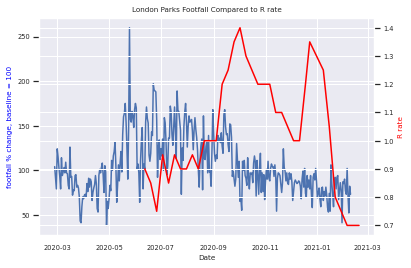

In [54]:
fig, ax = plt.subplots()
ax.plot(parksFootfall["date"],parksFootfall["value"])
ax.set_ylabel('footfall % change, baseline = 100',color='blue')
ax.set_xlabel('Date')

ax2 = ax.twinx()
ax2.set_ylabel('R rate',color='red')
ax2.plot(rRate['Date'],rRate['mean'], color='red')
# ax2.fill_between(rRate.Date, rRate.Lbound, rRate.Hbound)
plt.title('London Parks Footfall Compared to R rate')

plt.savefig('parksR',dpi=1000, bbox_inches='tight')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


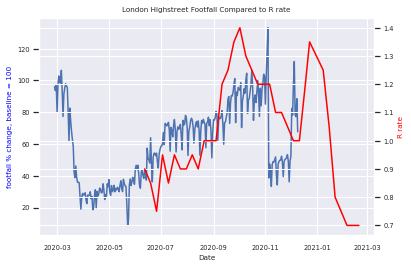

In [55]:
highstreetFootfall['date'] = pd.to_datetime(highstreetFootfall['date'])

fig, ax = plt.subplots()
ax.plot(highstreetFootfall["date"],highstreetFootfall["value"])
ax.set_ylabel('footfall % change, baseline = 100',color='blue')
ax.set_xlabel('Date')

ax2 = ax.twinx()
ax2.set_ylabel('R rate',color='red')
ax2.plot(rRate['Date'],rRate['mean'], color='red')
# ax2.fill_between(rRate.Date, rRate.Lbound, rRate.Hbound)
plt.title('London Highstreet Footfall Compared to R rate')
plt.savefig('highstreetR',dpi=1000, bbox_inches='tight')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


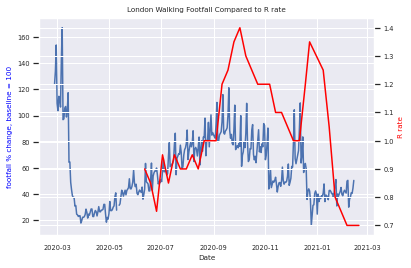

In [56]:
walkingFootfall['Date'] = pd.to_datetime(walkingFootfall['date'])

fig, ax = plt.subplots()
ax.plot(walkingFootfall["Date"],walkingFootfall["value"])
ax.set_ylabel('footfall % change, baseline = 100',color='blue')
ax.set_xlabel('Date')

ax2 = ax.twinx()
ax2.set_ylabel('R rate',color='red')
ax2.plot(rRate['Date'],rRate['mean'], color='red')
# ax2.fill_between(rRate.Date, rRate.Lbound, rRate.Hbound)
plt.title('London Walking Footfall Compared to R rate')
plt.savefig('walkingR',dpi=1000, bbox_inches='tight')

In [57]:
temp = walkingFootfall.merge(rRate, on='Date')

In [58]:
temp

,location,activity,date,change,value,source,roll,Date,Lbound,Hbound,mean
0,London,Walking,2020-06-05,-58.48,41.52,Apple,45.950000,2020-06-05,NaN,NaN,NaN
1,London,Walking,2020-06-12,-56.16,43.84,Apple,41.610000,2020-06-12,0.8,1.0,0.90
2,London,Walking,2020-06-19,-49.57,50.43,Apple,49.192857,2020-06-19,0.7,1.0,0.85
3,London,Walking,2020-06-26,-40.10,59.90,Apple,55.964286,2020-06-26,0.6,0.9,0.75
4,London,Walking,2020-07-03,-42.43,57.57,Apple,51.212857,2020-07-03,0.8,1.1,0.95
5,London,Walking,2020-07-10,-30.94,69.06,Apple,59.912857,2020-07-10,0.7,1.0,0.85
6,London,Walking,2020-07-17,-22.05,77.95,Apple,67.454286,2020-07-17,0.8,1.1,0.95
7,London,Walking,2020-07-24,-22.63,77.37,Apple,70.877143,2020-07-24,0.8,1.0,0.90
8,London,Walking,2020-07-31,-21.31,78.69,Apple,69.990000,2020-07-31,0.8,1.0,0.90
9,London,Walking,2020-08-07,-20.68,79.32,Apple,76.918571,2020-08-07,0.8,1.1,0.95


In [59]:
temp['mean'][1:-1].corr(temp['value'][1:-1])

0.2881684908087119

In [60]:
ageCases.head(3)

,area_name,area_code,date,age_band,age_lower,age_higher,cases,rolling_rate,rolling_sum,population,casePer100k
0,London,E12000007,2020-01-30,0 - 4 years,0.0,4.0,0,0.0,0,606004.0,0.0
1,London,E12000007,2020-01-30,5 - 9 years,5.0,9.0,0,0.0,0,602992.0,0.0
2,London,E12000007,2020-01-30,10 - 14 years,10.0,14.0,0,0.0,0,537605.0,0.0


In [61]:
pd.unique(ageCases['area_name'])

array(['London'], dtype=object)

In [62]:
age = pd.read_csv('/content/drive/MyDrive/Citadel Datathon 2021/London/ukmidyearestimates20192020ladcodes.csv', thousands=',')
age = age[0:33]
age = age.drop(age.columns[23:], axis=1)
age = age.drop(age.columns[[0,2]], axis =1)

In [63]:
age.iloc[:,2:] = age.iloc[:,2:].div(age['All ages'], axis=0) *100
age.head()

,Name,All ages,0 - 4,5 - 9,10 - 14,15 - 19,20 - 24,25 - 29,30 - 34,35 - 39,40 - 44,45 - 49,50 - 54,55 - 59,60 - 64,65 - 69,70 - 74,75 - 79,80 - 84,85 - 89,90+
0,Camden,270029.0,5.224624,7.029245,4.183995,5.570883,8.579449,10.968452,10.255195,8.322069,6.819268,6.395980,5.808635,4.826889,3.993275,3.374452,3.185954,2.181247,1.571683,1.004707,0.703998
1,City of London,9721.0,4.752597,6.563111,6.563111,3.569592,9.145150,10.935089,6.954017,6.511676,5.462401,6.624833,7.303775,6.470528,5.493262,5.050921,4.515996,2.890649,2.139698,1.080136,1.213867
2,Hackney,281120.0,7.199417,7.746870,7.746870,5.036995,5.928429,10.471685,13.417046,11.139727,7.580748,5.940524,5.368170,4.393853,3.396770,2.502846,1.934050,1.316164,1.019493,0.571642,0.372083
3,Hammersmith and Fulham,185143.0,6.028313,7.287880,7.287880,4.278855,8.199068,10.053850,10.054390,8.567972,7.561723,7.137726,6.380473,5.359641,3.954241,3.240198,2.897760,2.015199,1.446990,0.886882,0.514737
4,Haringey,268647.0,6.682747,7.560851,7.560851,5.370989,6.259515,8.472084,9.299936,9.481587,8.207425,7.140225,6.713271,5.546312,4.127349,3.284235,2.662974,1.808321,1.434596,0.829713,0.400153


In [64]:
age = age.drop(age.columns[[1]], axis =1)
age = age.sort_values('Name', ascending = True)

In [65]:
age = age.T
age.columns = age.iloc[0]
age = age.drop(age.index[[0]])

In [66]:
age=age.apply(pd.to_numeric, errors='coerce')
age.head()

Name,Barking and Dagenham,Barnet,Bexley,Brent,Bromley,Camden,City of London,Croydon,Ealing,Enfield,Greenwich,Hackney,Hammersmith and Fulham,Haringey,Harrow,Havering,Hillingdon,Hounslow,Islington,Kensington and Chelsea,Kingston upon Thames,Lambeth,Lewisham,Merton,Newham,Redbridge,Richmond upon Thames,Southwark,Sutton,Tower Hamlets,Waltham Forest,Wandsworth,Westminster
0 - 4,8.969686,6.633002,6.357562,7.291727,6.339367,5.224624,4.752597,7.158077,7.110466,7.150218,7.466434,7.199417,6.028313,6.682747,7.103838,6.691145,7.202398,7.337132,5.338458,5.279609,6.233557,5.682229,7.034678,7.097624,7.707273,7.373977,6.262530,6.265408,6.551522,6.767772,7.785315,6.547318,5.182594
5 - 9,10.643195,8.370193,8.007669,8.130187,7.958813,7.029245,6.563111,8.402420,8.522963,8.846774,8.460037,7.746870,7.287880,7.560851,8.066969,7.729472,8.534884,8.665564,6.099799,6.654113,8.075175,6.645933,7.890349,8.235374,8.463076,8.438448,8.543625,7.328984,8.451701,7.825217,8.316034,7.063884,6.905406
10 - 14,10.643195,8.370193,8.007669,8.130187,7.958813,4.183995,6.563111,8.402420,8.522963,8.846774,8.460037,7.746870,7.287880,7.560851,8.066969,7.729472,8.534884,8.665564,6.099799,6.654113,8.075175,6.645933,7.890349,8.235374,8.463076,8.438448,8.543625,7.328984,8.451701,7.825217,8.316034,7.063884,6.905406
15 - 19,6.218707,5.340656,5.622526,5.652711,5.124934,5.570883,3.569592,5.694707,5.459530,5.871885,5.182988,5.036995,4.278855,5.370989,5.432394,5.341512,5.736957,5.150208,4.657541,4.411096,5.226273,4.382672,4.787766,4.656061,5.669236,5.687008,4.539968,4.630054,4.843736,5.387920,5.045075,3.817676,4.931941
20 - 24,6.139799,5.434626,5.446117,6.707382,4.387427,8.579449,9.145150,5.087792,5.477083,5.624127,6.187010,5.928429,8.199068,6.259515,5.191511,5.576532,6.338515,5.654401,11.123163,6.204485,6.732129,7.151401,6.117211,5.072913,7.546993,6.335389,4.322313,7.226735,5.027890,8.699441,6.034305,6.603433,7.111286


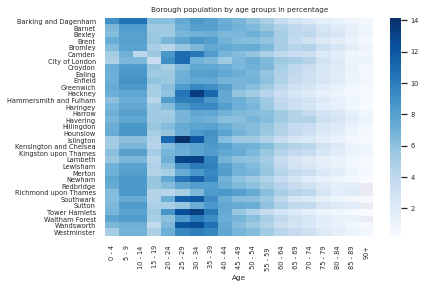

In [67]:
sns.heatmap(age.T,yticklabels=1, cmap='Blues')
plt.ylabel('')
plt.xlabel('Age')
plt.title('Borough population by age groups in percentage')
plt.savefig('Borough population by groups in percentage',dpi=1000, bbox_inches='tight')

# New Section

Stringency bar graph

In [231]:
from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis

ModuleNotFoundError: ignored

In [184]:
li=['United Kingdom', 'United States', 'Sweden', 'Taiwan','Germany','Italy']
owid = pd.read_csv('/content/drive/MyDrive/Citadel Datathon 2021/1_owid/owid-covid-data.csv')
owid = owid[['date','iso_code','location','stringency_index','reproduction_rate', 'total_cases_per_million','total_deaths']]
maxstring=owid.loc[owid['location'].isin(li)]
totalcases = owid.loc[owid['date']=='2021-01-04']
owid['date'] = pd.to_datetime(owid['date'])
owid

,date,iso_code,location,stringency_index,reproduction_rate,total_cases_per_million,total_deaths
0,2020-02-24,AFG,Afghanistan,8.33,NaN,0.026,NaN
1,2020-02-25,AFG,Afghanistan,8.33,NaN,0.026,NaN
2,2020-02-26,AFG,Afghanistan,8.33,NaN,0.026,NaN
3,2020-02-27,AFG,Afghanistan,8.33,NaN,0.026,NaN
4,2020-02-28,AFG,Afghanistan,8.33,NaN,0.026,NaN
...,...,...,...,...,...,...,...
58149,2020-12-16,ZWE,Zimbabwe,67.59,1.2,790.490,313.0
58150,2020-12-17,ZWE,Zimbabwe,67.59,1.2,798.362,314.0
58151,2020-12-18,ZWE,Zimbabwe,69.44,1.2,810.540,316.0
58152,2020-12-19,ZWE,Zimbabwe,69.44,NaN,817.537,318.0


In [187]:
maxstring['date'] = pd.to_datetime(maxstring['date'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


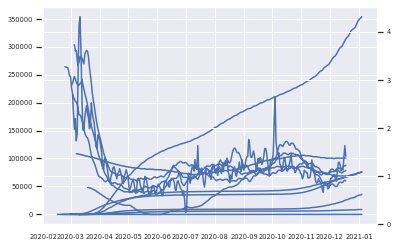

In [188]:
fig, ax = plt.subplots()

ax.plot(maxstring['date'],maxstring['total_deaths'])

ax2 = ax.twinx()
ax2.plot(maxstring['date'],maxstring['reproduction_rate'])

In [189]:
mob = pd.read_csv('/content/drive/MyDrive/Citadel Datathon 2021/London/applemobilitytrends-2021-02-16.csv')
mob = mob.loc[mob['region'].isin(li)]
mob = mob.loc[mob['transportation_type'] == 'transit']
del mob['geo_type']
del mob['transportation_type']
del mob['sub-region']
del mob['alternative_name']
del mob['country']

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [190]:
mob = mob.T

In [191]:
mob.columns = mob.iloc[0]

In [192]:
mob = mob.drop(mob.index[0])

In [193]:
mob.info()

<class 'pandas.core.frame.DataFrame'>
Index: 401 entries, 2020-01-13 to 2021-02-16
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Germany         399 non-null    object
 1   Italy           399 non-null    object
 2   Sweden          399 non-null    object
 3   Taiwan          399 non-null    object
 4   United Kingdom  399 non-null    object
 5   United States   399 non-null    object
dtypes: object(6)
memory usage: 21.9+ KB


In [194]:
mob=mob.reset_index()

In [209]:
mob['index']= pd.to_datetime(mob['index'])

In [210]:
mob=mob.dropna()
mob.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 399 entries, 0 to 400
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   index           399 non-null    datetime64[ns]
 1   Germany         399 non-null    object        
 2   Italy           399 non-null    object        
 3   Sweden          399 non-null    object        
 4   Taiwan          399 non-null    object        
 5   United Kingdom  399 non-null    object        
 6   United States   399 non-null    object        
dtypes: datetime64[ns](1), object(6)
memory usage: 24.9+ KB


-0.026504781175693756

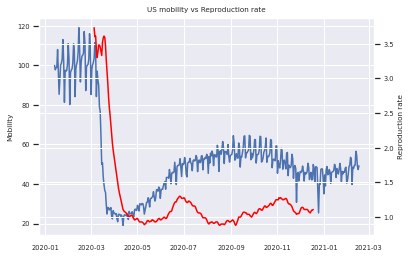

In [258]:
us = maxstring.loc[maxstring['location']=='United States']
us = us.dropna()
fig, ax = plt.subplots()

ax.plot(mob['index'],mob['United States'])
ax2 = ax.twinx()
ax2.plot(us['date'],us['reproduction_rate'], color='red')
ax.set_ylabel('Mobility')
ax2.set_ylabel('Reproduction rate')
plt.title('US mobility vs Reproduction rate')
plt.savefig('MRus',dpi=1000, bbox_inches='tight')

mob['date']=mob['index']
temp=mob.merge(us, on='date')
pd.to_numeric(temp['United States']).corr(temp['reproduction_rate'], method='spearman')


0.4562442001228829

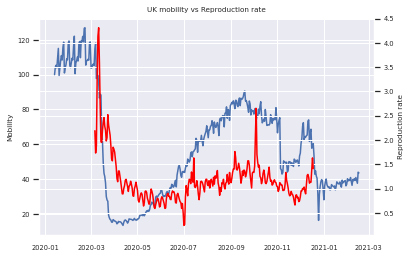

In [259]:
us = maxstring.loc[maxstring['location']=='United Kingdom']
us = us.dropna()
fig, ax = plt.subplots()

ax.plot(mob['index'],mob['United Kingdom'])
ax2 = ax.twinx()
ax2.plot(us['date'],us['reproduction_rate'], color='red')
ax.set_ylabel('Mobility')
ax2.set_ylabel('Reproduction rate')
plt.title('UK mobility vs Reproduction rate')
plt.savefig('MRuk',dpi=1000, bbox_inches='tight')
mob['United States'].corr(us['reproduction_rate'])

mob['date']=mob['index']
temp=mob.merge(us, on='date')
pd.to_numeric(temp['United Kingdom']).corr(temp['reproduction_rate'], method='spearman')

0.20671582858512655

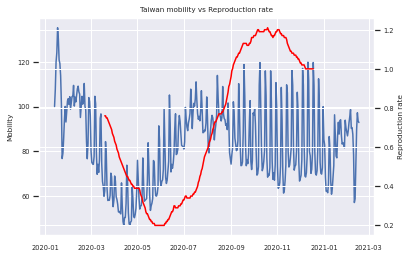

In [260]:
us = maxstring.loc[maxstring['location']=='Taiwan']
us = us.dropna()
fig, ax = plt.subplots()

ax.plot(mob['index'],mob['Taiwan'])
ax2 = ax.twinx()
ax2.plot(us['date'],us['reproduction_rate'], color='red')
ax.set_ylabel('Mobility')
ax2.set_ylabel('Reproduction rate')
plt.title('Taiwan mobility vs Reproduction rate')
plt.savefig('MRtaiwan',dpi=1000, bbox_inches='tight')

mob['date']=mob['index']
temp=mob.merge(us, on='date')
pd.to_numeric(temp['Taiwan']).corr(temp['reproduction_rate'], method='spearman')

0.4182339861770453

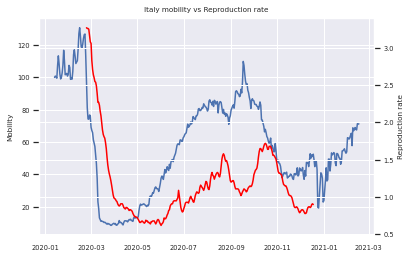

In [261]:
us = maxstring.loc[maxstring['location']=='Italy']
us = us.dropna()
fig, ax = plt.subplots()

ax.plot(mob['index'],mob['Italy'])
ax2 = ax.twinx()
ax2.plot(us['date'],us['reproduction_rate'], color='red')
ax.set_ylabel('Mobility')
ax2.set_ylabel('Reproduction rate')
plt.title('Italy mobility vs Reproduction rate')
plt.savefig('MRitaly',dpi=1000, bbox_inches='tight')

mob['date']=mob['index']
temp=mob.merge(us, on='date')
pd.to_numeric(temp['Italy']).corr(temp['reproduction_rate'], method='spearman')

0.3418436954644673

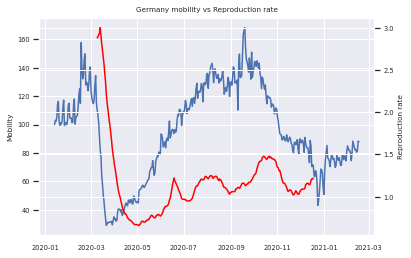

In [262]:
us = maxstring.loc[maxstring['location']=='Germany']
us = us.dropna()
fig, ax = plt.subplots()

ax.plot(mob['index'],mob['Germany'])
ax2 = ax.twinx()
ax2.plot(us['date'],us['reproduction_rate'], color='red')
ax.set_ylabel('Mobility')
ax2.set_ylabel('Reproduction rate')
plt.title('Germany mobility vs Reproduction rate')
plt.savefig('MRgermany',dpi=1000, bbox_inches='tight')

mob['date']=mob['index']
temp=mob.merge(us, on='date')
pd.to_numeric(temp['Germany']).corr(temp['reproduction_rate'], method='spearman')

-0.3387638659308241

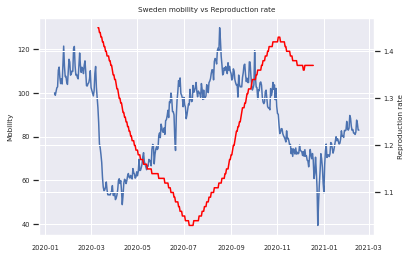

In [263]:
us = maxstring.loc[maxstring['location']=='Sweden']
us = us.dropna()
fig, ax = plt.subplots()

ax.plot(mob['index'],mob['Sweden'])
ax2 = ax.twinx()
ax2.plot(us['date'],us['reproduction_rate'], color='red')
ax.set_ylabel('Mobility')
ax2.set_ylabel('Reproduction rate')
plt.title('Sweden mobility vs Reproduction rate')
plt.savefig('MRsweden',dpi=1000, bbox_inches='tight')

mob['date']=mob['index']
temp=mob.merge(us, on='date')
pd.to_numeric(temp['Sweden']).corr(temp['reproduction_rate'], method='spearman')


In [230]:
# mob['United States']
us['reproduction_rate']

54712    2.19
54713    1.73
54714    1.88
54715    3.23
54716    4.13
         ... 
54995    1.13
54996    1.13
54997    1.38
54998    1.63
54999    1.41
Name: reproduction_rate, Length: 288, dtype: float64

In [234]:
mob['date']=mob['index']

In [236]:
temp=mob.merge(us, on='date')

In [237]:
temp

,index,Germany,Italy,Sweden,Taiwan,United Kingdom,United States,date,iso_code,location,stringency_index,reproduction_rate,total_cases_per_million,total_deaths
0,2020-03-06,127.44,57.32,108.83,104.58,114.68,111.5,2020-03-06,GBR,United Kingdom,11.11,2.19,5.509,1.0
1,2020-03-07,134.51,52,112.09,101.24,118.05,107.32,2020-03-07,GBR,United Kingdom,11.11,1.73,6.319,2.0
2,2020-03-08,115.27,46.69,102.58,79.21,97.76,84.23,2020-03-08,GBR,United Kingdom,11.11,1.88,7.115,2.0
3,2020-03-09,110.61,37.69,97.69,69.69,99,97.1,2020-03-09,GBR,United Kingdom,11.11,3.23,9.280,3.0
4,2020-03-10,106.74,23.02,93.21,74.16,99.54,92.48,2020-03-10,GBR,United Kingdom,11.11,4.13,13.095,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
281,2020-12-14,88.87,52.76,74.1,77.96,66.85,44.87,2020-12-14,GBR,United Kingdom,72.22,1.13,27617.872,64500.0
282,2020-12-15,85.26,50.05,71.54,70.1,68.69,45.9,2020-12-15,GBR,United Kingdom,72.22,1.13,27891.405,65006.0
283,2020-12-16,70.43,52.06,69.86,71.92,57.78,42.08,2020-12-16,GBR,United Kingdom,72.22,1.38,28264.088,65618.0
284,2020-12-17,71.62,51.07,72.24,79.17,58.69,42.29,2020-12-17,GBR,United Kingdom,72.22,1.63,28787.495,66150.0


In [245]:
pd.to_numeric(temp['Sweden']).corr(temp['reproduction_rate'])

-0.038505387595370706

In [244]:
temp.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 286 entries, 0 to 285
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   index                    286 non-null    datetime64[ns]
 1   Germany                  286 non-null    object        
 2   Italy                    286 non-null    object        
 3   Sweden                   286 non-null    object        
 4   Taiwan                   286 non-null    object        
 5   United Kingdom           286 non-null    object        
 6   United States            286 non-null    object        
 7   date                     286 non-null    datetime64[ns]
 8   iso_code                 286 non-null    object        
 9   location                 286 non-null    object        
 10  stringency_index         286 non-null    float64       
 11  reproduction_rate        286 non-null    float64       
 12  total_cases_per_million  286 non-nul

In [241]:
temp.dropna()


,index,Germany,Italy,Sweden,Taiwan,United Kingdom,United States,date,iso_code,location,stringency_index,reproduction_rate,total_cases_per_million,total_deaths
0,2020-03-06,127.44,57.32,108.83,104.58,114.68,111.5,2020-03-06,GBR,United Kingdom,11.11,2.19,5.509,1.0
1,2020-03-07,134.51,52,112.09,101.24,118.05,107.32,2020-03-07,GBR,United Kingdom,11.11,1.73,6.319,2.0
2,2020-03-08,115.27,46.69,102.58,79.21,97.76,84.23,2020-03-08,GBR,United Kingdom,11.11,1.88,7.115,2.0
3,2020-03-09,110.61,37.69,97.69,69.69,99,97.1,2020-03-09,GBR,United Kingdom,11.11,3.23,9.280,3.0
4,2020-03-10,106.74,23.02,93.21,74.16,99.54,92.48,2020-03-10,GBR,United Kingdom,11.11,4.13,13.095,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
281,2020-12-14,88.87,52.76,74.1,77.96,66.85,44.87,2020-12-14,GBR,United Kingdom,72.22,1.13,27617.872,64500.0
282,2020-12-15,85.26,50.05,71.54,70.1,68.69,45.9,2020-12-15,GBR,United Kingdom,72.22,1.13,27891.405,65006.0
283,2020-12-16,70.43,52.06,69.86,71.92,57.78,42.08,2020-12-16,GBR,United Kingdom,72.22,1.38,28264.088,65618.0
284,2020-12-17,71.62,51.07,72.24,79.17,58.69,42.29,2020-12-17,GBR,United Kingdom,72.22,1.63,28787.495,66150.0
